# Sprint 深層学習スクラッチ ディープニューラルネットワーク

In [1]:
import numpy as np

In [2]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## 1.このSprintについて
### Sprintの目的
- スクラッチを通してニューラルネットワークの発展的内容を理解する

### どのように学ぶか
スクラッチで作成したニューラルネットワークの実装を拡張していきます。

## 2.ディープニューラルネットワークスクラッチ
前回は3層のニューラルネットワークを作成しましたが、今回はこれを任意の層数に拡張しやすいものに書き換えていきます。その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。

このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指します。

名前は新しくScratchDeepNeuralNetrowkClassifierクラスとしてください。

### 層などのクラス化
クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。

**手を加える箇所**

- 層の数
- 層の種類（今後畳み込み層など他のタイプの層が登場する）
- 活性化関数の種類
- 重みやバイアスの初期化方法
- 最適化手法

そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成します。

実装方法は自由ですが、簡単な例を紹介します。サンプルコード1のように全結合層と活性化関数のインスタンスを作成し、サンプルコード2,3のようにして使用します。それぞれのクラスについてはこのあと解説します。

### 【問題1】全結合層のクラス化

全結合層のクラス化を行なってください。

以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。

なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。

また、引数として自身のインスタンス`self`を渡すこともできます。これを利用して`self.optimizer.update(self)`という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。

初期化方法と最適化手法のクラスについては後述します。

In [3]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
    
    # optimazer がadagradの際に呼び出す
    def adagrad_initialize(self, n_nodes1, n_nodes2):
        self.H_W = np.ones(n_nodes1 * n_nodes2).reshape(n_nodes1, -1)
        self.H_B = np.ones(n_nodes2)

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        A = np.dot(X, self.W) + self.B
        return A
    def backward(self, dA, Z):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            一層前の活性化関数の出力結果
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # dZを計算
        dZ = np.dot(dA, self.W.T)
        # 更新
        self = self.optimizer.update(self, dA, Z)
        return dZ

### 【問題2】初期化方法のクラス化
初期化を行うコードをクラス化してください。

前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。

これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

In [4]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_nodes2)
        return B

### 【問題3】最適化手法のクラス化
最適化手法のクラス化を行なってください。

最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときに`self.optimizer.update(self)`のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。

これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [5]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer, dA, Z):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        dA : 後ろから流れてきた勾配
        Z : layerより一層前の活性化関数の出力
        """
        # バイアスの更新
        dB = dA.sum(axis=0)
        layer.B -= dB * self.lr
        # 重みの更新
        dW = np.dot(Z.T, dA)
        layer.W -= dW * self.lr

### 【問題4】活性化関数のクラス化
活性化関数のクラス化を行なってください。

ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。

In [6]:
class Sigmoid():
    def forward(self, A):
        Z = 1.0 / (1.0 + np.exp(-A))
        return Z
    def backward(self, A):
        # dZとアダマール計算する値
        return (1.0 - self.forward(A)) * self.forward(A)

class Tanh():
    def forward(self, A):
        Z = np.tanh(A)
        return Z
    
    def backward(self, A):
        # dZとアダマール計算する値
        return 1.0 - np.power(self.forward(A), 2)

class Softmax():
    def __init__(self, y_label_one_hot):
        # one_hot_encodingされた正解ラベル
        self.y_label_one_hot = y_label_one_hot

    def forward(self, A):
        # オーバーフローを防ぐ
        A -= np.max(A)
        Z = np.exp(A) / np.exp(A).sum(axis=1)[:, np.newaxis]
        return Z

    def _cross_entropy_error(self, A):
        return -(np.log(self.forward(A)) * self.y_label_one_hot).sum(axis=1).mean()

    def backward(self, A):
        # 交差エントロピー誤差の計算
        loss = self._cross_entropy_error(A)
        # dA　の計算
        dA = self.forward(A) - self.y_label_one_hot
        # dA, loss
        return dA, loss

### 発展的要素
活性化関数や重みの初期値、最適化手法に関してこれまで見てきた以外のものを実装していきます。

### 【問題5】ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。

ReLUは以下の数式です。
$$
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases}
$$

$x$ : ある特徴量。スカラー

実装上は`np.maximum`を使い配列に対してまとめて計算が可能です。

[numpy.maximum — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.maximum.html)

一方、バックプロパゲーションのための $x$ に関する $f(x)$ の微分は以下のようになります。
$$
\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases}
$$

数学的には微分可能ではないですが、 $x=0$ のとき $0$ とすることで対応しています。

フォワード時の $x$ の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [7]:
class ReLU():
    def forward(self, A):
        Z = np.maximum(A, 0)
        return Z
    def backward(self, A):
        # dZとアダマール計算する値
        return np.where(A > 0, 1, 0)

### 【問題6】重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは **Xavier**の初期値 （またはGlorotの初期値）、ReLUのときは **He**の初期値 が使われます。

XavierInitializerクラスと、HeInitializerクラスを作成してください。

### Xavierの初期値
Xavierの初期値における標準偏差 $σ$ は次の式で求められます。
$$
\sigma = \frac{1}{\sqrt{n}}
$$
$n$ : 前の層のノード数

**《論文》**

[Glorot, X., & Bengio, Y. (n.d.). Understanding the difficulty of training deep feedforward neural networks.](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

### Heの初期値
Heの初期値における標準偏差 $σ$ は次の式で求められます。
$$
\sigma = \sqrt{\frac{2}{n}}
$$

**《論文》**

[He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.](https://arxiv.org/pdf/1502.01852.pdf)

In [8]:
class XavierInitializer:
    """
    Xavierによる初期化
    Parameters
    ----------
    前の層のノード数の逆数の平方根を標準偏差とする分布
    """
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W :
        """
        W = np.sqrt(1 / n_nodes1) * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes1 : int
          後の層のノード数
        Returns
        ----------
        B :
        """
        B = np.zeros(n_nodes2)
        return B

In [9]:
class HeInitializer:
    """
    Heによる初期化
    Parameters
    ----------
    前の層のノード数の逆数を２倍した平方根を標準偏差とする分布
    """
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W :
        """
        W = np.sqrt(2 / n_nodes1) * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes1 : int
          後の層のノード数
        Returns
        ----------
        B :
        """
        B = np.zeros(n_nodes2)
        return B

- biasは０で初期化　[参考](https://qiita.com/m-hayashi/items/02065a2e2ec3e2269e0b)

### 【問題7】最適化手法
学習率は学習過程で変化させていく方法が一般的です。基本的な手法である *AdaGrad* のクラスを作成してください。

まず、これまで使ってきたSGDを確認します。
$$
W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) \\
B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})
$$

$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）

$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 $L$ の勾配

$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 $L$ の勾配

$E()$ : ミニバッチ方向にベクトルの平均を計算

続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。

更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和 $H$ を保存しておき、その分だけ学習率を小さくします。

学習率は重み一つひとつに対して異なることになります。
$$
H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\
W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\
$$

$H_i$ : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）

$H_i^{\prime}$ : 更新した $H_i$

**《論文》**

[Duchi JDUCHI, J., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization * Elad Hazan. Journal of Machine Learning Research (Vol. 12).](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

In [10]:
class AdaGrad:
    """
    更新された分だけ、その重みに対する学習率を下げていく
    Parameters
    --------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer, dA, Z):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        dA : 後ろから流れてきた勾配
        Z : layerより一層前の活性化関数の出力
        H_B, H_W : class_FCで初期値1で作成
        """
        # バイアスの更新
        dB = dA.sum(axis=0)
        layer.H_B += np.power(dB, 2)
        layer.B -= dB * self.lr / np.sqrt(layer.H_B)
        
        # 重みの更新
        dW = np.dot(Z.T, dA)
        layer.H_W += np.power(dW, 2)
        layer.W -= dW * self.lr / np.sqrt(layer.H_W)

### 【問題8】クラスの完成
任意の構成で学習と推定が行えるScratchDeepNeuralNetworkClassifierクラスを完成させてください。

In [11]:
from copy import deepcopy
import numpy as np
class ScratchDeepNeuralNetworkClassifier():
    """
    多層なニューラルネットワーク分類器
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self, verbose=False, random_state=None, activation='relu', epoch=10, batch_size=20, lr=0.0001, hidden_layer_sizes=(400, 200,), initialize=None, sigma=None, optimize='adagrad'):
        self.verbose = verbose
        # 学習率
        self.lr = lr
        # 層のノード数のタプル
        self.hidden_layer_sizes = hidden_layer_sizes
        # バッチサイズ
        self.batch_size = batch_size
        # epochの回数
        self.epoch = epoch
        # 活性化関数の名前　'sigmoid', 'tanh', 'relu'
        self.activation = activation
        # 乱数の設定
        self.random_state = random_state
        # 初期値の設定方法 'gauss', 'xavier', 'he'
        self.initialize = initialize
        # 初期値をガウス分布で定める際の標準偏差
        self.sigma = sigma
        # 最適化手法 'sgd', 'adagrad'
        self.optimize = optimize
        
        # 出力クラス数
        self.n_output = None
        # 出力カテゴリの配列
        self.categories_ = None
        # 重みの情報リスト
        self.coefs_ = None
        self.intercepts_ = None
        # epoch毎に損失を記録
        self.losses = np.zeros(self.epoch)
        self.val_losses = None
        # fitの時にvalデータがあるフラグ
        self.val_flag = None    

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。
        
        Parameters
        ----------
        X_train : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y_train : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # random_stateが設定されている場合はseed設定
        if type(self.random_state) == int:
            np.random.seed(self.random_state)
        
        # 変数情報
        self.n_samples, self.n_features = X_train.shape
        # valデータの確認
        if type(X_val) == np.ndarray and type(y_val) == np.ndarray:
            if X_val.shape == (y_val.shape[0], self.n_features):
                self.val_flag = True
                self.val_losses = np.zeros(self.epoch)
        
        # 目的変数をone_hot_encoding
        from sklearn.preprocessing import OneHotEncoder
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
        if self.val_flag:
            y_val_one_hot = enc.transform(y_val[:, np.newaxis])
        
        # 出力カテゴリの配列
        self.categories_ = enc.categories_[0]
        # 出力クラス数を特定
        self.n_output = len(self.categories_)
        
        # 初期化のインスタンス作成
        # initializeで指定がない時、sigmoid, tanhではxavier, reluではhe
        if self.initialize is None:
            if self.activation == 'relu':
                self.initialize = 'he'
            elif self.activation == 'sigmoid' or self.activation == 'tanh':
                self.initialize = 'xavier'
        # self.initializeに応じてinitializerのインスタンスを作成
        if self.initialize == 'he':
            initializer = HeInitializer()
        elif self.initialize == 'xavier':
            initializer = XavierInitializer()
        elif self.initialize == 'gauss':
            if self.sigma is None:
                self.sigma = 0.01
            initializer = SimpleInitializer(self.sigma)
        
        # 最適化のインスタンス作成
        if self.optimize == 'adagrad':
            optimizer = AdaGrad(self.lr)
        elif self.optimize == 'sgd':
            optimizer = SGD(self.lr)
        
        # 重みを初期化し、インスタンスをリストへ
        fc_lst = []
        row = self.n_features
        for n_nodes in list(self.hidden_layer_sizes) + [self.n_output]:
            fc = FC(row, n_nodes, initializer, optimizer)
            
            # self.optimize　が 'adagrad' の際、インスタンスへH_W, H_Bを持たせる
            if self.optimize == 'adagrad':
                fc.adagrad_initialize(row, n_nodes)
            
            fc_lst.append(fc)
            row = n_nodes
            
        # 活性化関数のインスタンス
        if self.activation == 'relu':
            self.act = ReLU()
        elif self.activation == 'sigmoid':
            self.act = Sigmoid()
        elif self.activation == 'tanh':
            self.act = Tanh()
        else:
            print('not proper activation name')
        
        # epoch　でループ
        for n_epoch in range(self.epoch):
            # 各々のバッチの損失の記録
            batches_losses = np.zeros(self.n_samples // self.batch_size, dtype=np.float64)
            if self.val_flag:
                batches_val_losses = np.zeros(self.n_samples // self.batch_size, dtype=np.float64)
            
            # バッチを取り出し、バッチでループ
            get_mini_batch = GetMiniBatch(X_train, y_train_one_hot, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:
                
                # forward propagation
                # 全結合層の結果をリストで管理、ex [0, A_1, A_2]
                A_lst = [0]
                # 、活性化の結果をリストで管理、ex [X, Z_1, Z_2]
                Z_lst = [mini_X_train]
                Z = mini_X_train
                if self.val_flag:
                    Z_val = X_val
                
                # 各層をループ
                for i in range(len(self.hidden_layer_sizes)):
                    
                    A = fc_lst[i].forward(Z)
                    # actでZを計算
                    Z = self.act.forward(A)
                    
                    if self.val_flag:
                        A_val = fc_lst[i].forward(Z_val)
                        Z_val = self.act.forward(A_val)
                    
                    # A, Z　をdeepcopyしてリストへ保管　（deepcopy必要？）
                    A_lst.append(deepcopy(A))
                    Z_lst.append(deepcopy(Z))
                
                # 最後の出力層、forward_propagation
                # 最終層の活性化関数のインスタンス
                self.last_act = Softmax(mini_y_train)
                A = fc_lst[i+1].forward(Z)
                Z = self.last_act.forward(A)
                
                if self.val_flag:
                    last_act_val = Softmax(y_val_one_hot)
                    A_val = fc_lst[i+1].forward(Z_val)
                    Z_val = last_act_val.forward(A_val) 

                # 最後の出力層、back_propagation
                # 最終層のAをもとに、dA　と　損失を求める（損失は記録）
                dA, batches_losses[get_mini_batch._counter - 1] = self.last_act.backward(A)
                if self.val_flag:
                    _, batches_val_losses[get_mini_batch._counter - 1] = last_act_val.backward(A_val)
                
                # back propagation
                # fc, A, Zを逆順で取り出す
                for fc, A, Z in zip(fc_lst[::-1], A_lst[::-1], Z_lst[::-1]):
                    # dZ の勾配を求める、関数内でW、Bを更新
                    dZ = fc.backward(dA, Z)
                    # dAを求める、dZ　と　活性化関数のアダマール積、最後のdAはゼロになる
                    dA = dZ * self.act.backward(A)
  
            #　バッチのループが終わったら損失を合計し、記録
            self.losses[n_epoch] = batches_losses.sum()
            if self.val_flag:
                self.val_losses[n_epoch] = batches_val_losses.sum()
        
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose is True:
                print('epoch : {} finished'.format(n_epoch))
                print('train_loss : {}'.format(self.losses[n_epoch]))
                if self.val_flag:
                    print('val_loss : {}'.format(self.val_losses[n_epoch]))
        
        # 学習が終わったら重み、バイアスを変数へ記録
        self.coefs_ = [fc.W for fc in fc_lst]
        self.intercepts_ = [fc.B for fc in fc_lst]
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        # 活性化関数の出力結果をpredで管理
        pred = X

        # 各層をループ
        for n_layer in range(len(self.hidden_layer_sizes)):
            A = np.dot(pred, self.coefs_[n_layer]) + self.intercepts_[n_layer]
            pred = self.act.forward(A)

        # 最後の出力層
        A = np.dot(pred, self.coefs_[-1]) + self.intercepts_[-1]
        # 最後の活性化関数
        pred = self.last_act.forward(A)

        # 列、横方向に最大のインデックスを取得し、出力カテゴリのself.categories_の値を返す
        return self.categories_[np.argmax(pred, axis=1)]

## 3. 検証

### 【問題9】学習と推定
層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。

In [12]:
import time

In [13]:
# 設定しているパラメーターの表示
def display_params(clf):
    parameters = deepcopy(vars(clf))
    delete_params = ['verbose', 'n_output', 'categories_', 'coefs_', 'intercepts_', 'losses', 'val_losses', 'val_flag', 'n_samples', 'n_features', 'act', 'last_act']
    for params in delete_params:
        del parameters[params]
    print('Paremeters : ')
    print(parameters)
    return parameters

In [14]:
# Accuracy_scoreの計算
from sklearn.metrics import accuracy_score
def acc_score(X_test, y_test, clf):
    score = accuracy_score(y_test, clf.predict(X_test))
    print('Accuracy_score : {}'.format(score))
    return score

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
# 損失関数のプロット
def loss_plot(clf):
    plt.plot(range(clf.epoch), clf.losses, label='train_loss')
    if clf.val_flag:
        plt.plot(range(clf.epoch), clf.val_losses, label='val_loss')
    plt.xlabel('n_epoch')
    plt.title('model_loss')
    plt.legend()
    plt.show()

##### MNISTデータでは処理に時間がかかるので、まず簡単なデータでいくつか試してみる

In [16]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X, y = make_classification(n_samples=100, random_state=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, stratify=y,random_state=1)

Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.92


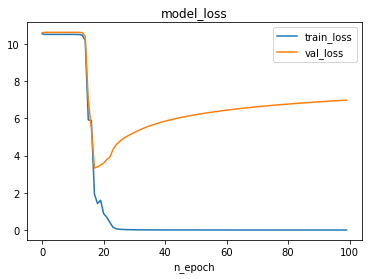


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


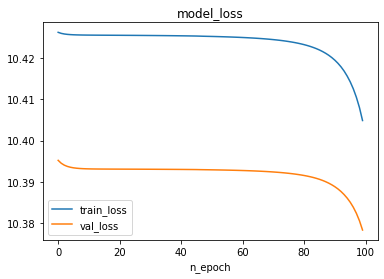


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.92


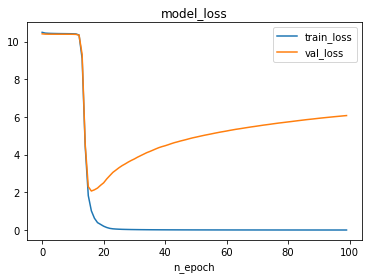


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


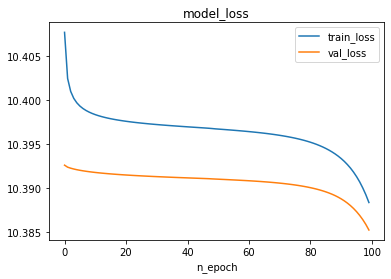


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


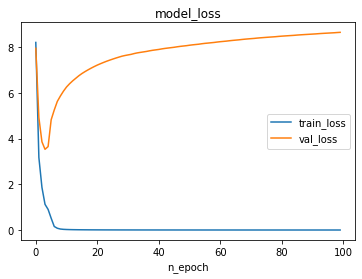


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.96


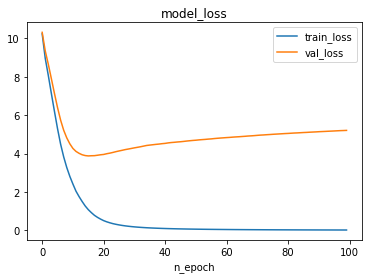


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


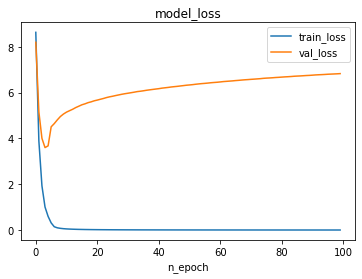


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


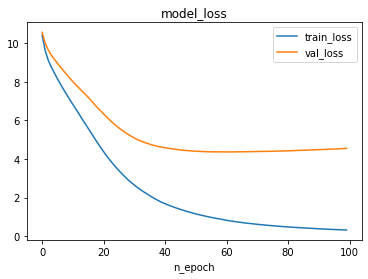


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


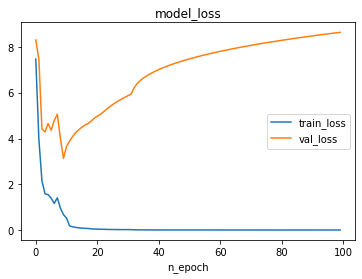


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


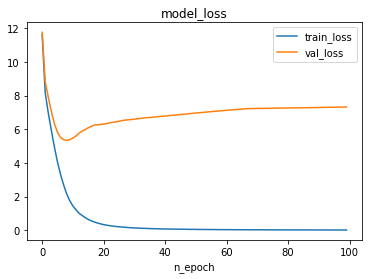


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.96


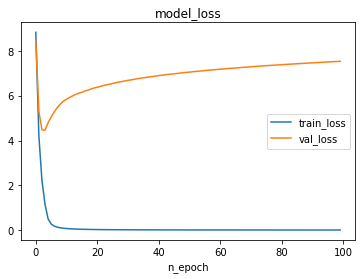


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.88


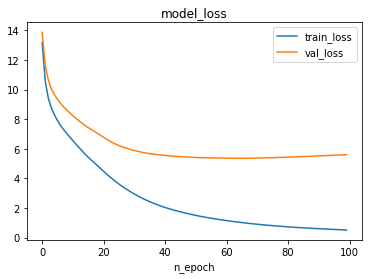


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.92


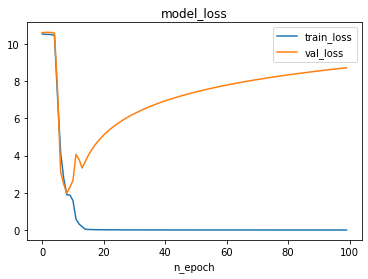


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.92


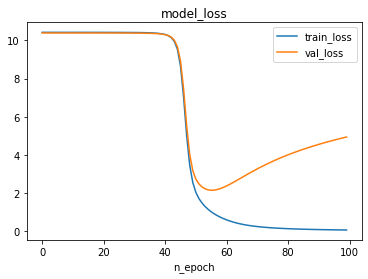


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.92


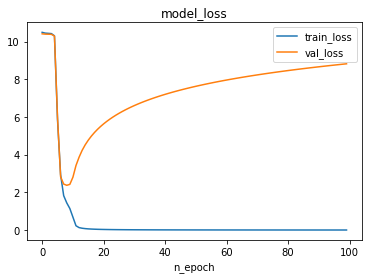


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.92


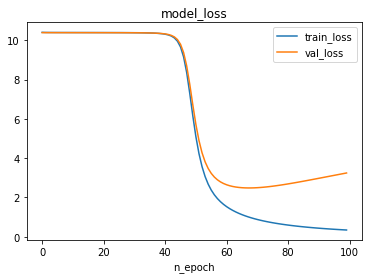


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


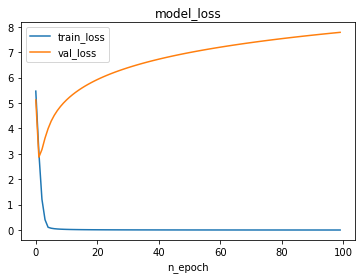


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


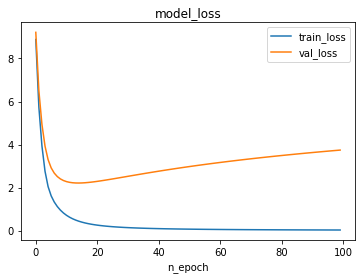


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


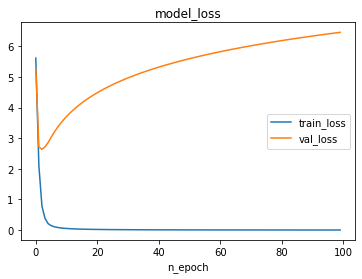


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.96


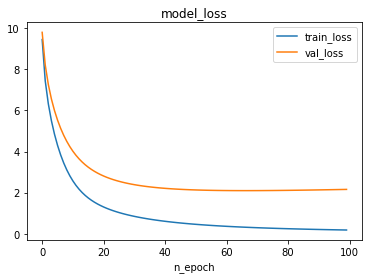


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


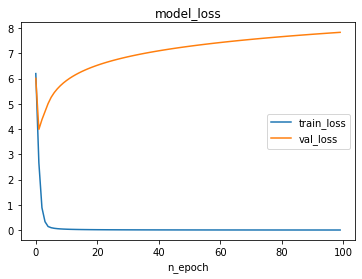


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.96


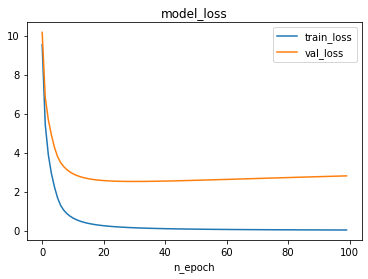


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


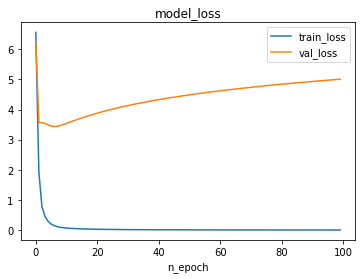


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.96


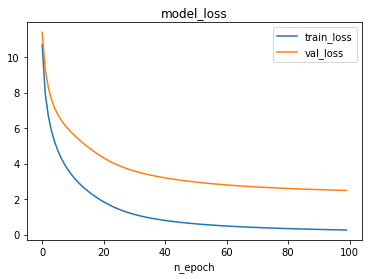


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.92


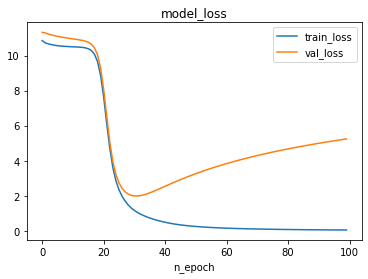


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


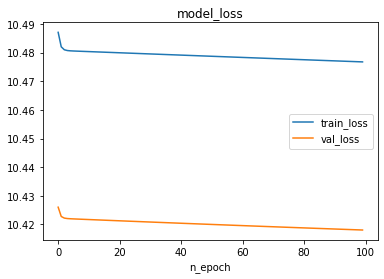


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.96


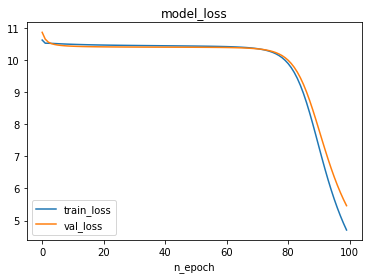


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


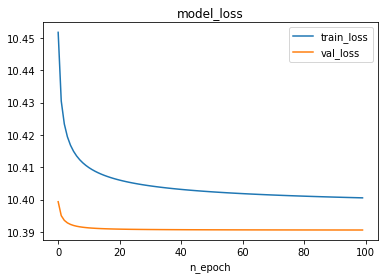


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


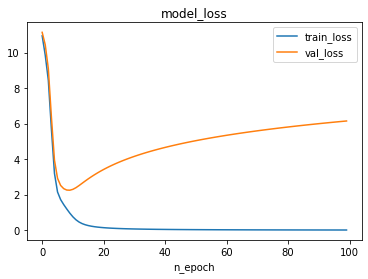


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


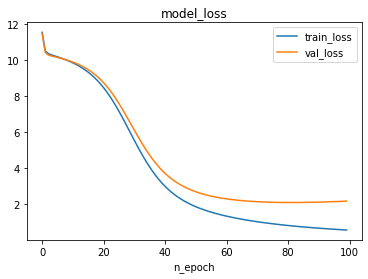


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


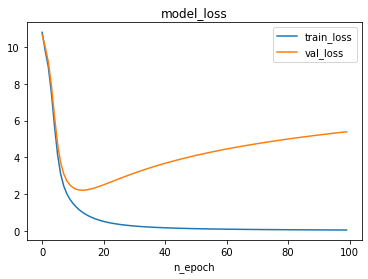


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.96


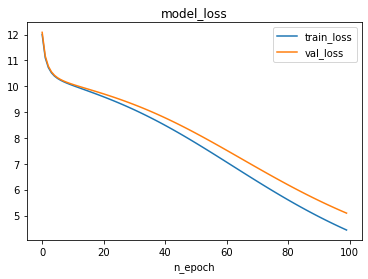


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


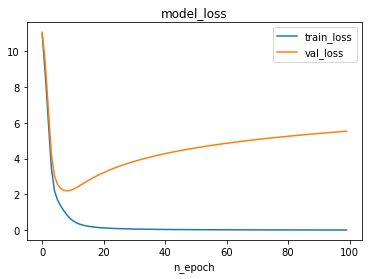


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.96


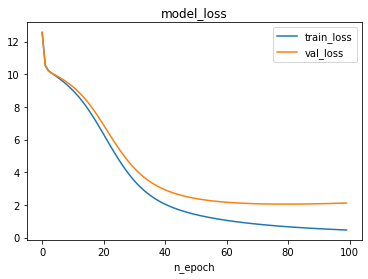


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


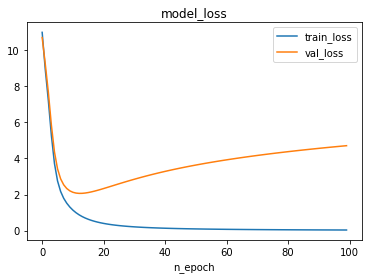


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.96


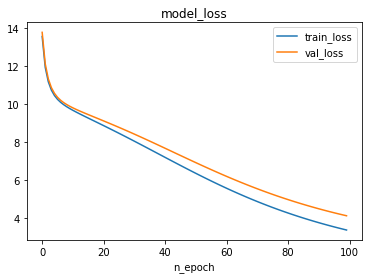


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


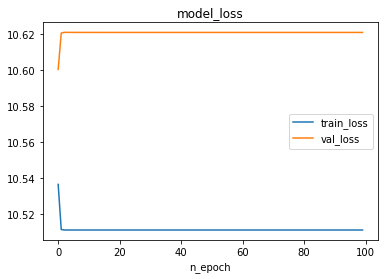


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


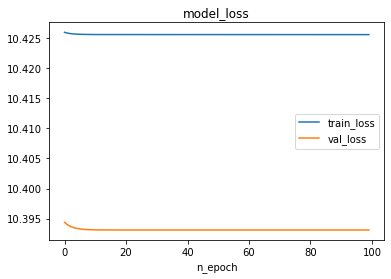


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


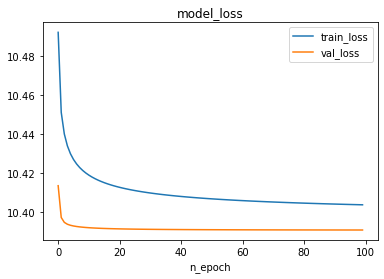


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


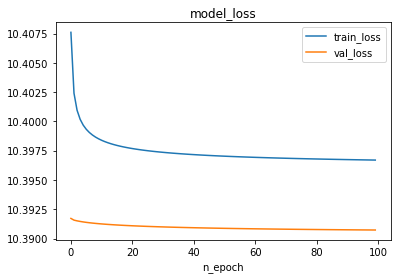


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.88


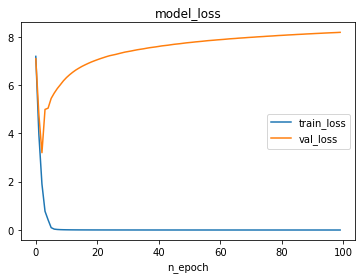


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


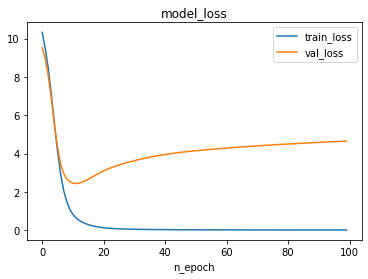


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


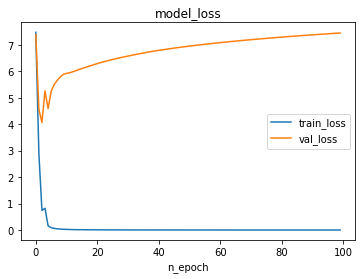


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.88


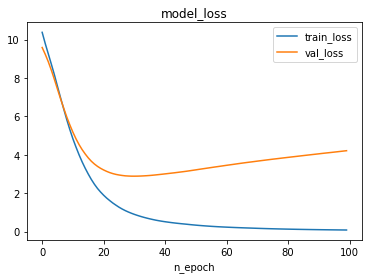


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


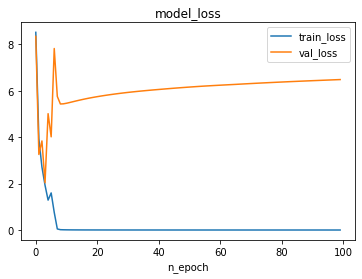


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


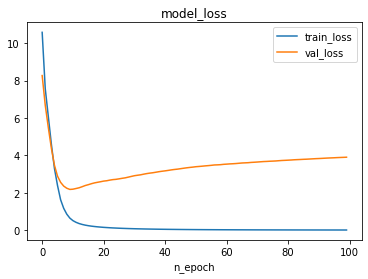


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.88


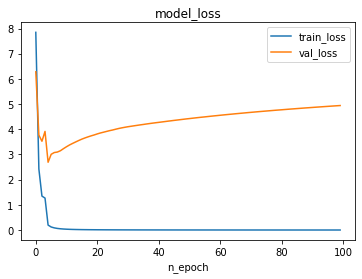


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


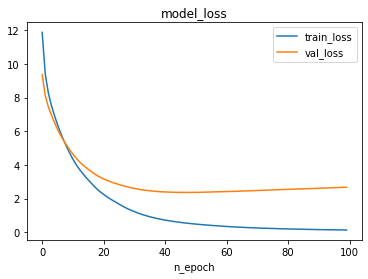


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


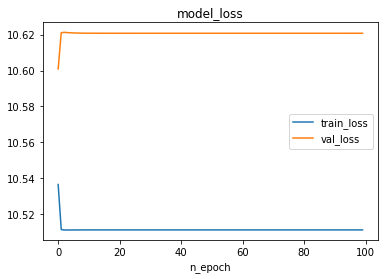


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


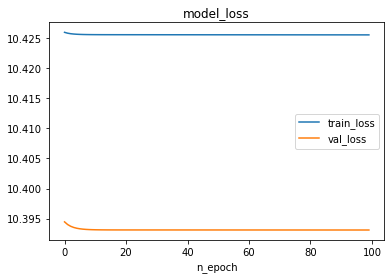


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


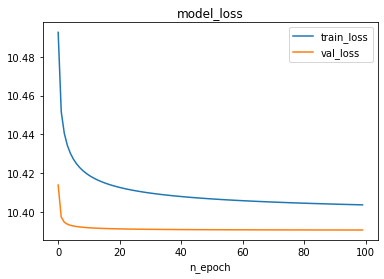


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


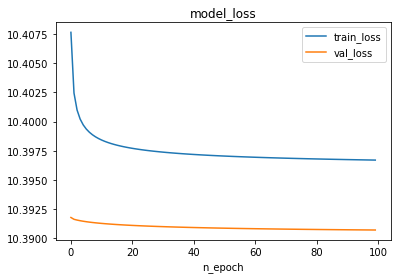


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


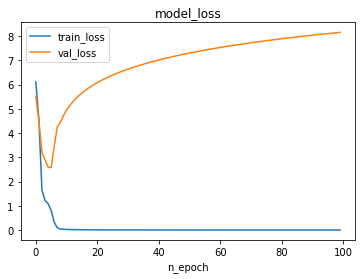


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.96


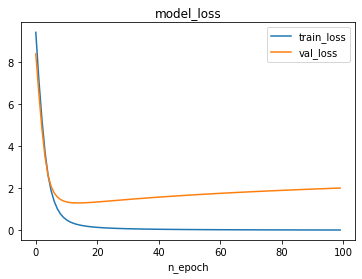


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.96


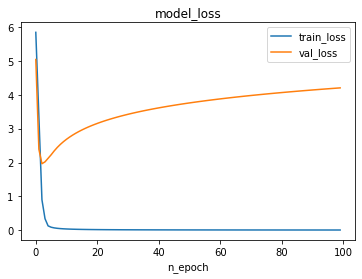


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


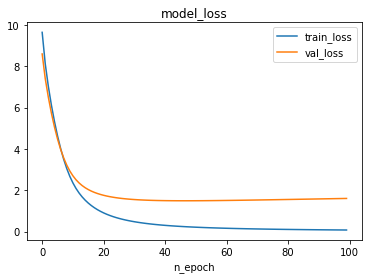


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


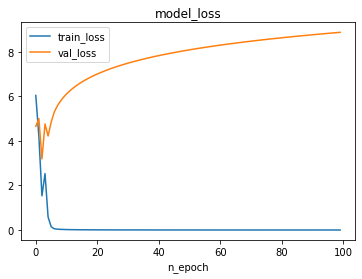


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


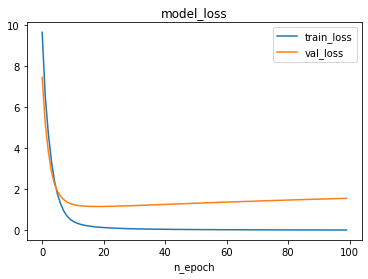


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.96


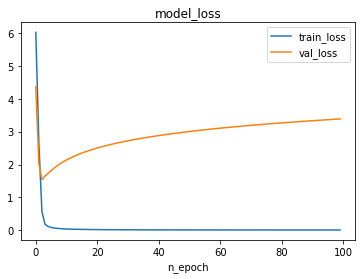


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


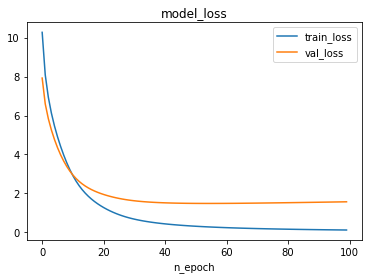


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


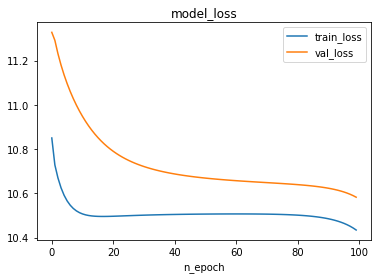


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


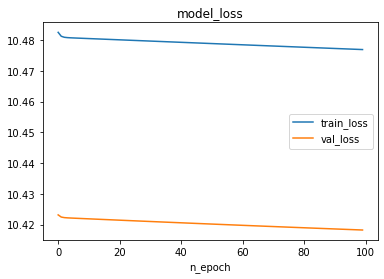


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


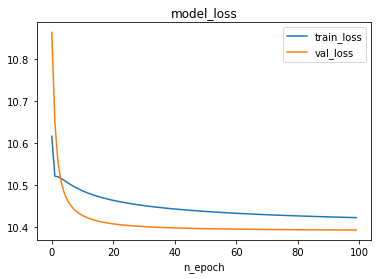


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


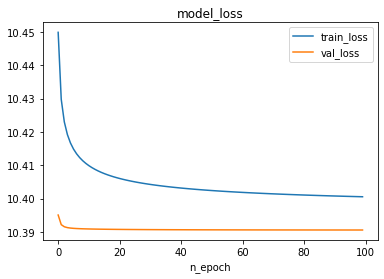


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


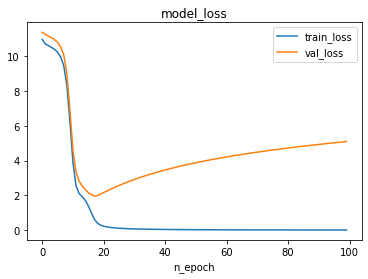


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.96


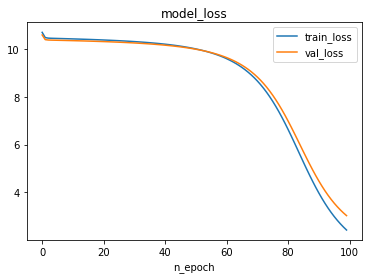


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


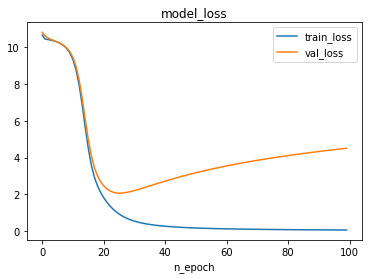


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.84


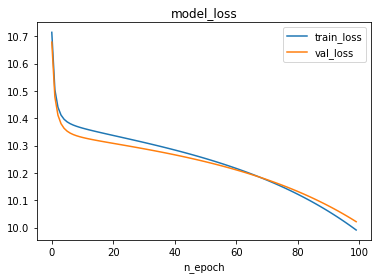


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


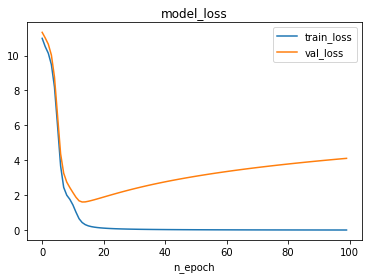


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


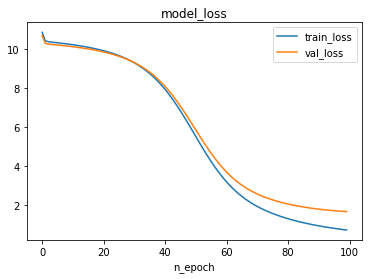


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


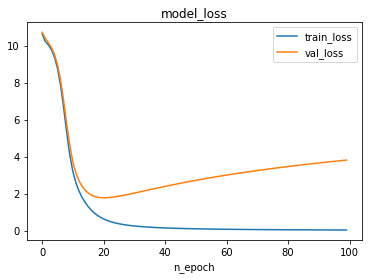


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.96


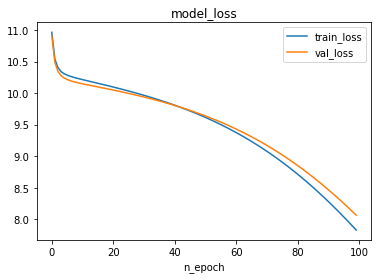


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


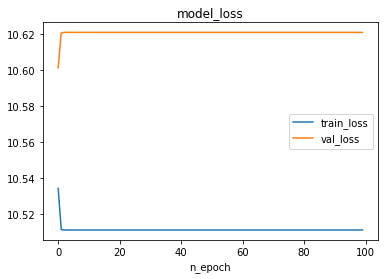


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


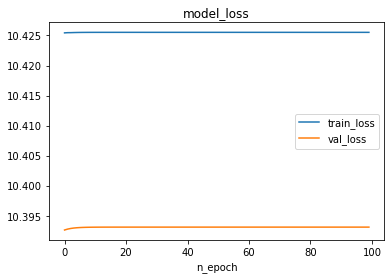


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


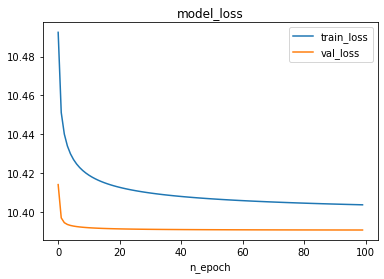


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


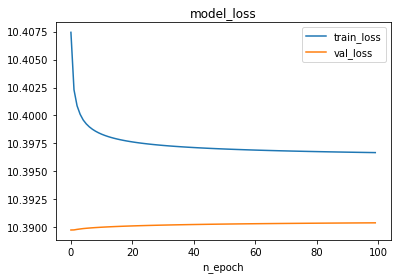


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


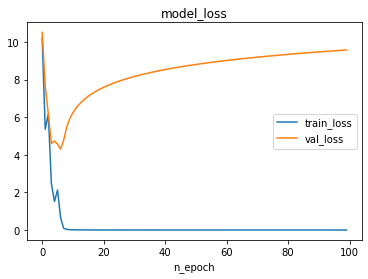


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


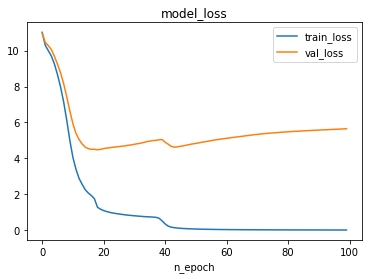


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


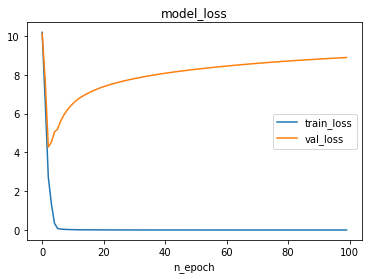


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.88


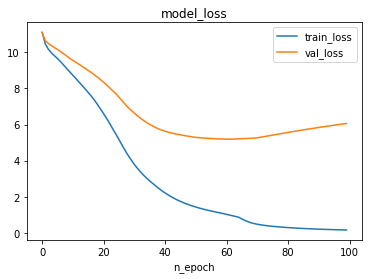


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.8


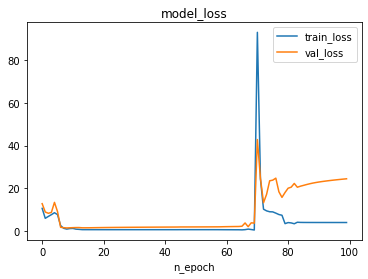


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


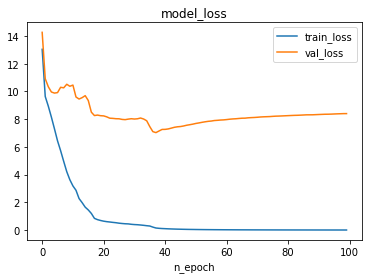


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


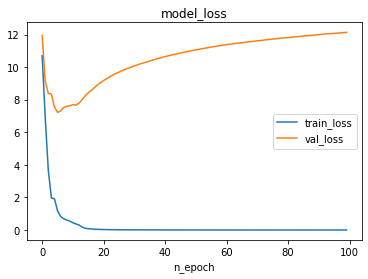


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.68


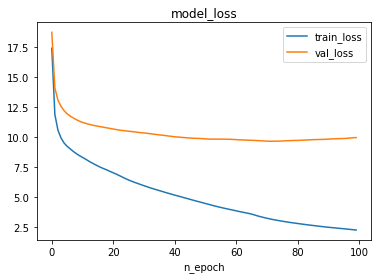


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


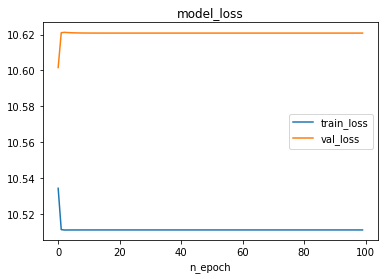


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


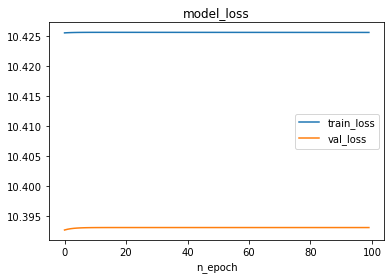


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


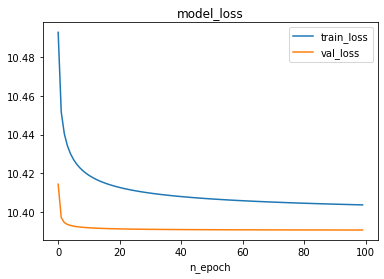


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


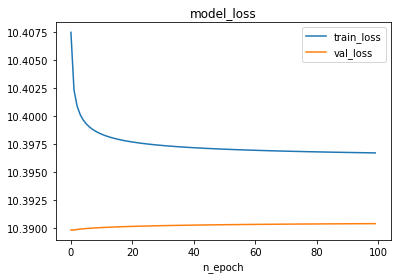


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


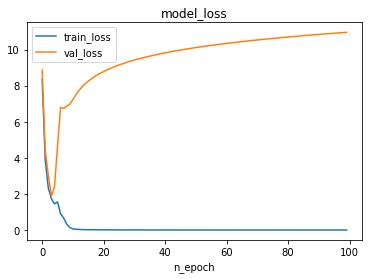


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.96


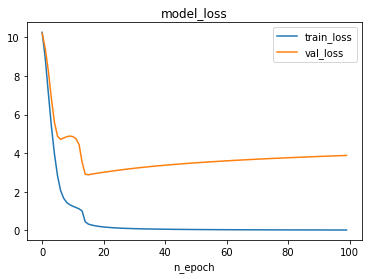


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


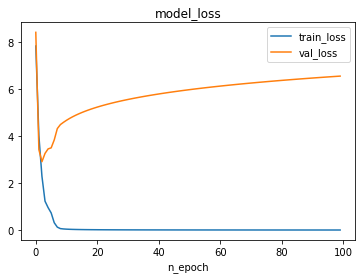


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.96


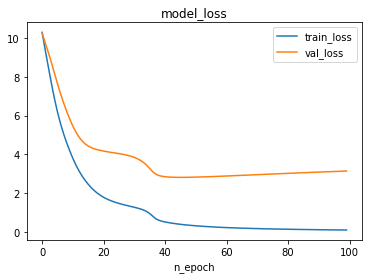


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.96


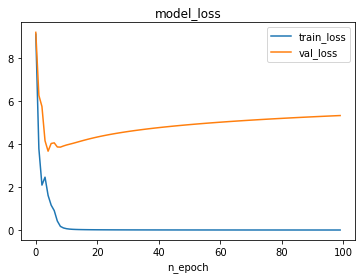


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.96


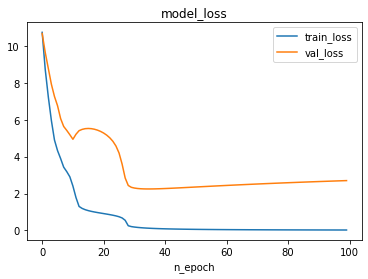


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


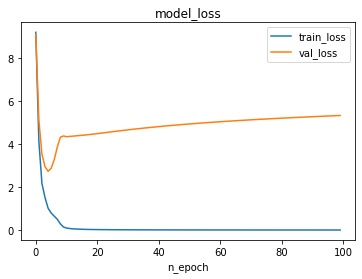


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'tanh', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


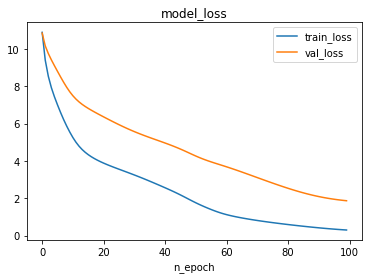


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


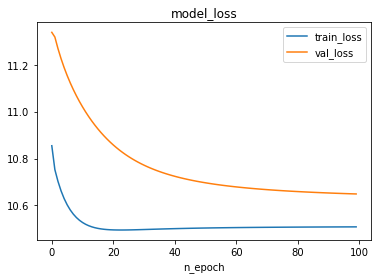


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


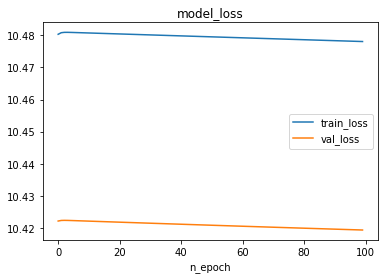


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


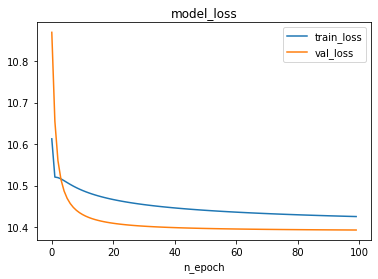


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


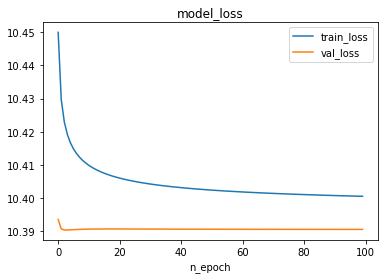


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


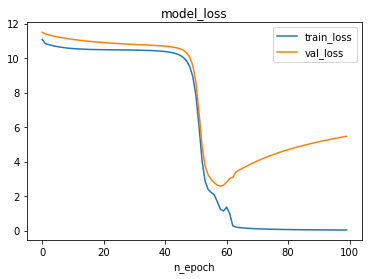


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.52


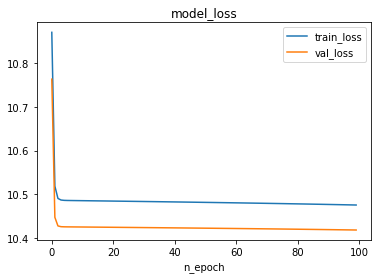


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


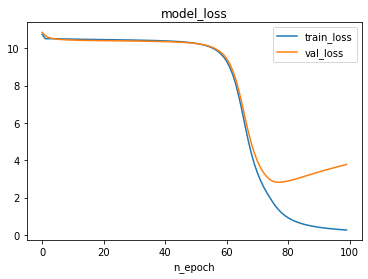


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.52


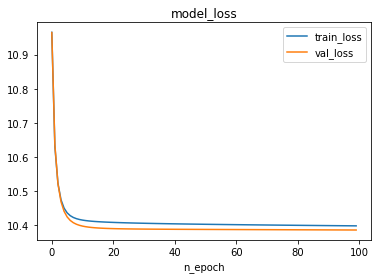


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


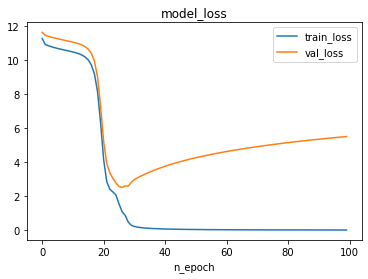


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.6


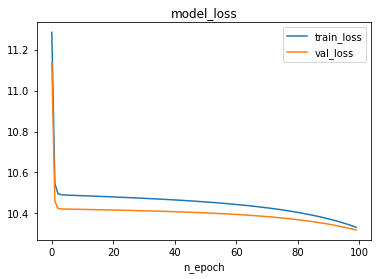


Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


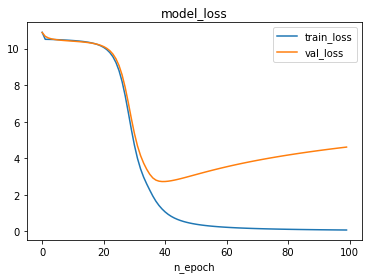


Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.56


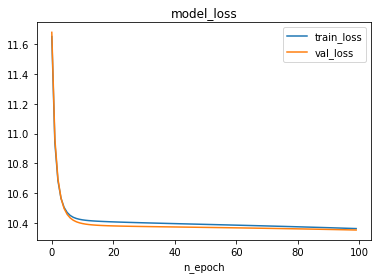


time : 98.1[s]


In [17]:
start = time.time()
params_lst = []
for hidden_layer_sizes in [(15, 10), (20, 15, 10), (10, 10, 10, 10)]:
    for activation in ['relu', 'tanh', 'sigmoid']:
        for initialize in ['gauss', 'xavier', 'he']:
            for optimize in ['sgd', 'adagrad']:
                for lr in [0.1, 0.01]:
                    clf = ScratchDeepNeuralNetworkClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, initialize=initialize, optimize=optimize, lr=lr, epoch=100, batch_size=5, random_state=0)
                    clf.fit(X_train2, y_train2, X_test2, y_test2)
                    params = display_params(clf)
                    acc = acc_score(X_test2, y_test2, clf)
                    loss_plot(clf)
                    print()
                    if acc < 0.8:
                        params_lst.append(params)
print("time : {:,.1f}[s]".format(time.time() - start))

- 損失関数が下がりきっていないものをいくつかある様子がある
- 収束していない（Accuracy_score=0.8未満のものを抽出）はパラメーター保存

In [18]:
print(len(params_lst))
for params in params_lst:
    print(params)

33
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 100, 'activation': 'relu', 'random_

- 多層にすると損失関数の動きが少しおかしく？なる
- また収束しなかったものの多くが初期化の方法がgauss分布である
- 収束しなかったもののepoch10000へ増やしてみて再度検証する

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.92


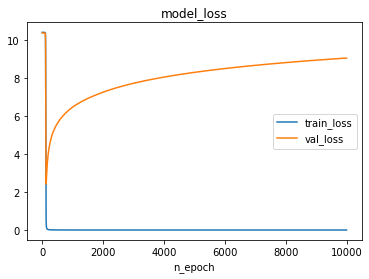

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.92


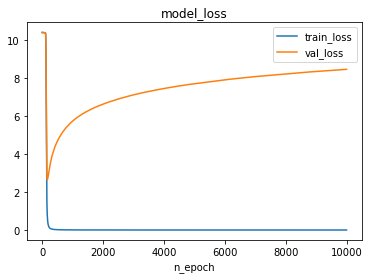

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.92


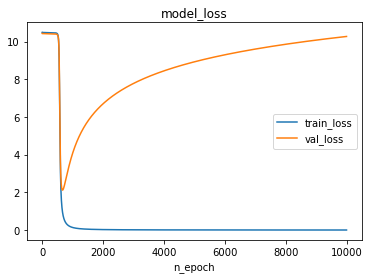

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (15, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.92


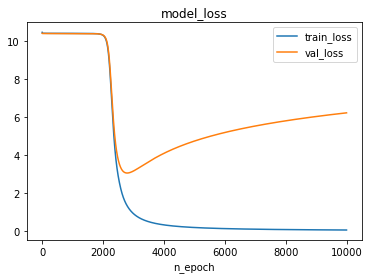

Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


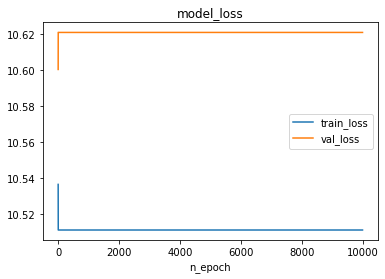

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.92


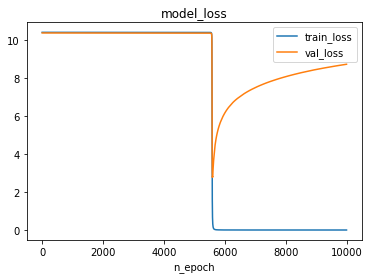

Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.92


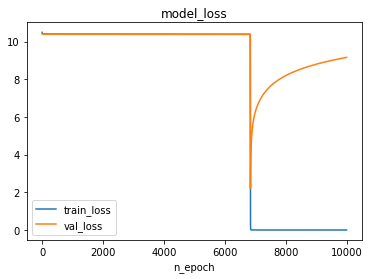

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.92


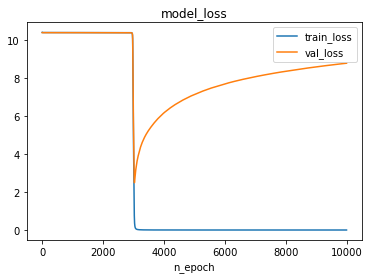

Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.92


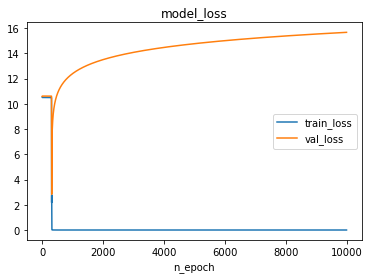

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.92


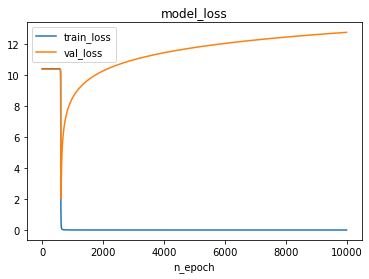

Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.92


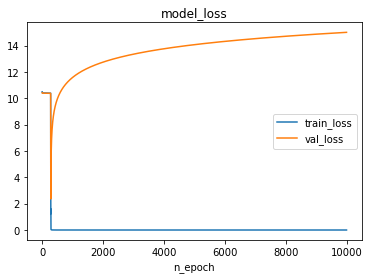

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.92


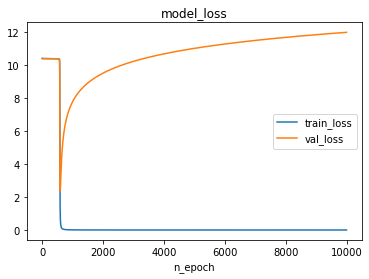

Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.92


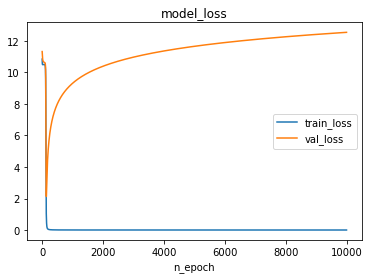

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.92


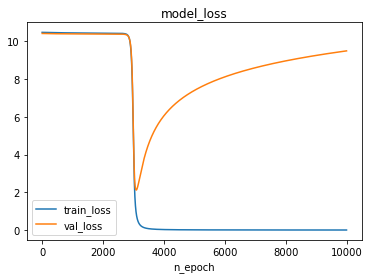

Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.88


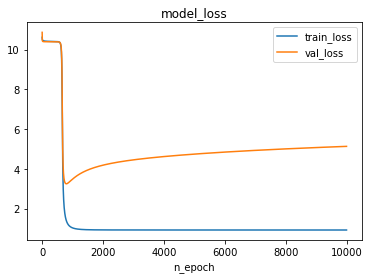

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (20, 15, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


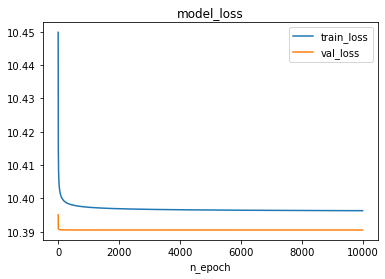

Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


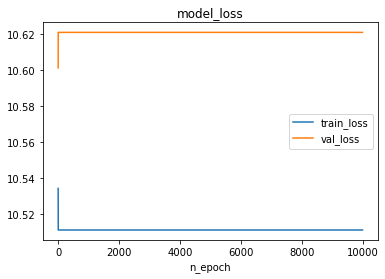

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


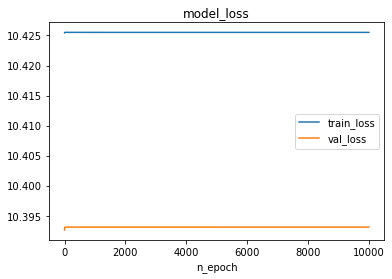

Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


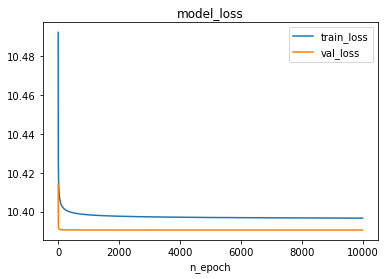

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'relu', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


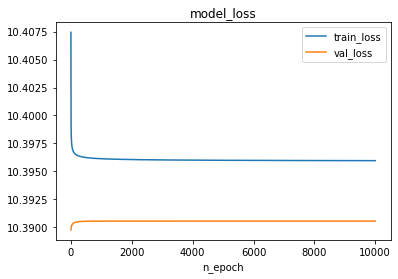

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'relu', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.8


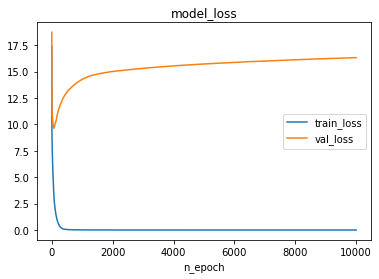

Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


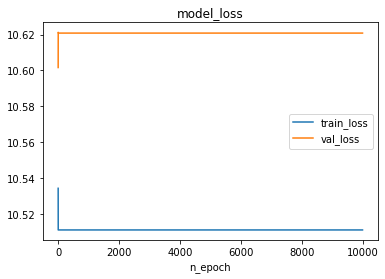

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


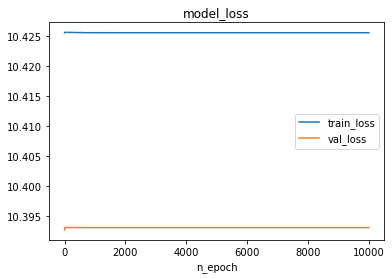

Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


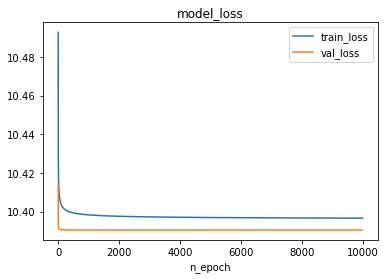

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'tanh', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


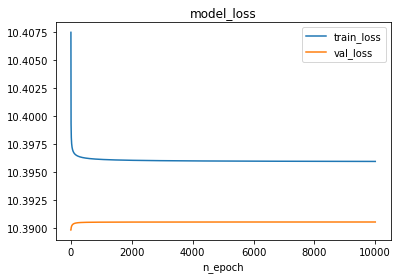

Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.92


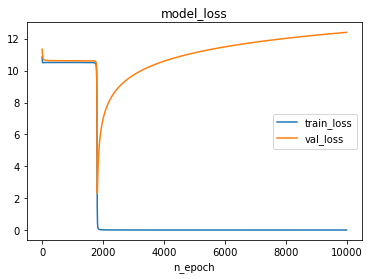

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'sgd'}
Accuracy_score : 0.52


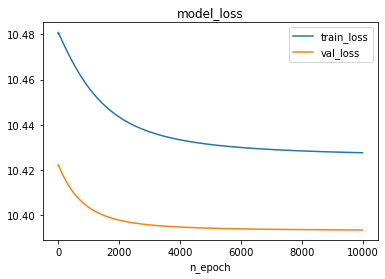

Paremeters : 
{'lr': 0.1, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.92


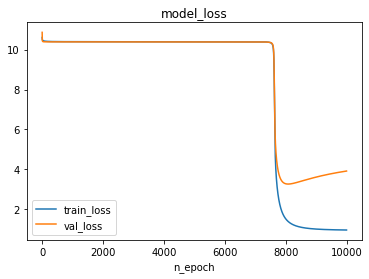

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'gauss', 'sigma': 0.01, 'optimize': 'adagrad'}
Accuracy_score : 0.52


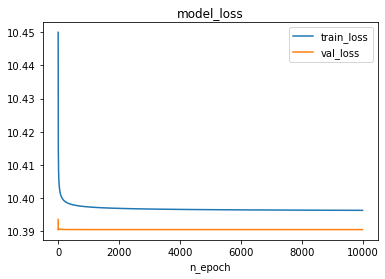

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


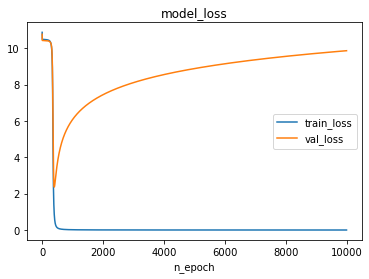

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


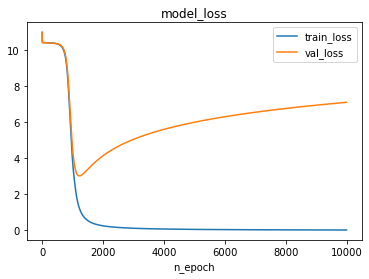

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'sgd'}
Accuracy_score : 0.92


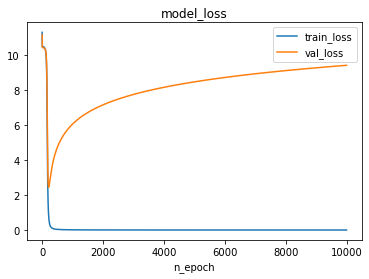

Paremeters : 
{'lr': 0.01, 'hidden_layer_sizes': (10, 10, 10, 10), 'batch_size': 5, 'epoch': 10000, 'activation': 'sigmoid', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.92


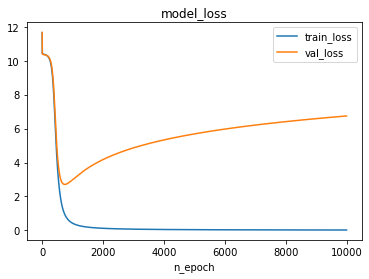

In [19]:
for params in params_lst:
    params['epoch'] = 10000
    clf = ScratchDeepNeuralNetworkClassifier(**params)
    clf.fit(X_train2, y_train2, X_test2, y_test2)
    display_params(clf)
    acc_score(X_test2, y_test2, clf)
    loss_plot(clf)

- epoch回数を増やすと、収束するものもあった
- 収束しないものは他のパラメーターが影響していると想定

##### MNISTデータ

In [20]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

- 平滑化

In [21]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

- 前処理

In [22]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


- いくつかのパターンで学習させ、学習器を保存

In [23]:
'''
start = time.time()
scratch = ScratchDeepNeuralNetworkClassifier(hidden_layer_sizes=(400, 200), activation='tanh', optimize='adagrad', epoch=20, batch_size=50, random_state=0)
scratch.fit(X_train, y_train, X_test, y_test)
print("time : {:,.1f}[s]".format(time.time() - start))
'''

'\nstart = time.time()\nscratch = ScratchDeepNeuralNetworkClassifier(hidden_layer_sizes=(400, 200), activation=\'tanh\', optimize=\'adagrad\', epoch=20, batch_size=50, random_state=0)\nscratch.fit(X_train, y_train, X_test, y_test)\nprint("time : {:,.1f}[s]".format(time.time() - start))\n'

In [24]:
'''
# scratchした学習器を保存
import pickle
with open('Scratch_DNNC_clf3_Sprint10', 'wb') as f:
    pickle.dump(scratch, f)
'''

"\n# scratchした学習器を保存\nimport pickle\nwith open('Scratch_DNNC_clf3_Sprint10', 'wb') as f:\n    pickle.dump(scratch, f)\n"

Paremeters : 
{'lr': 0.0001, 'hidden_layer_sizes': (200, 150, 100, 50), 'batch_size': 50, 'epoch': 20, 'activation': 'relu', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.8938


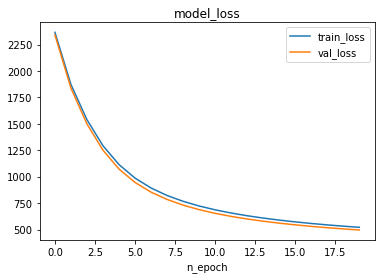

In [25]:
# 学習器を呼び出す
import pickle
with open('Scratch_DNNC_clf1_Sprint10', 'rb') as f:
    saved_scratch_clf = pickle.load(f)
display_params(saved_scratch_clf)
acc_score(X_test, y_test, saved_scratch_clf)
loss_plot(saved_scratch_clf)

Paremeters : 
{'lr': 0.0001, 'hidden_layer_sizes': (400, 200), 'batch_size': 50, 'epoch': 20, 'activation': 'relu', 'random_state': 0, 'initialize': 'he', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.9


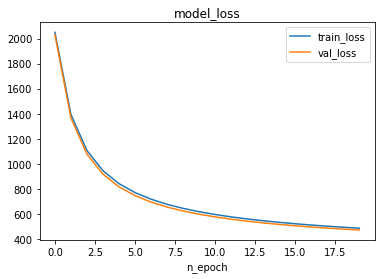

In [26]:
# 学習器を呼び出す
import pickle
with open('Scratch_DNNC_clf2_Sprint10', 'rb') as f:
    saved_scratch_clf = pickle.load(f)
display_params(saved_scratch_clf)
acc_score(X_test, y_test, saved_scratch_clf)
loss_plot(saved_scratch_clf)

Paremeters : 
{'lr': 0.0001, 'hidden_layer_sizes': (400, 200), 'batch_size': 50, 'epoch': 20, 'activation': 'tanh', 'random_state': 0, 'initialize': 'xavier', 'sigma': None, 'optimize': 'adagrad'}
Accuracy_score : 0.8905


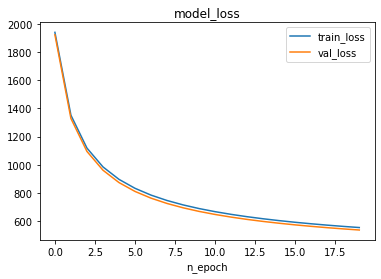

In [27]:
# 学習器を呼び出す
import pickle
with open('Scratch_DNNC_clf3_Sprint10', 'rb') as f:
    saved_scratch_clf = pickle.load(f)
display_params(saved_scratch_clf)
acc_score(X_test, y_test, saved_scratch_clf)
loss_plot(saved_scratch_clf)

- MNISTデータで３パターン学習
- 3パターンともうまく学習が進めていられると思うが、完全には学習が完了しきっていない様子。epoch, lrをあげれば収束すると想定